In [1]:
import os
import csv
import torch
import torchvision.transforms as transforms
from itertools import islice
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
import cv2
from torchvision.utils import make_grid
%matplotlib inline

In [1]:
DATA_DIR = '/home/atharva/jupyter_lab/facial-expression-analysis/fer2013.csv'

In [3]:
data_df=pd.read_csv(DATA_DIR)
data_df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [6]:
classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [7]:
class DataSet(torch.utils.data.Dataset):

    def __init__(self,transform=None, images=None, emotions=None):
        self.transform = transform
        self.images = images
        self.emotions = emotions

    def __getitem__(self, index):
        image = self.images[index]
        emotion = self.emotions[index]
        if self.transform is not None:
            image = self.transform(image)
        return image, emotion

    def __len__(self):
        return len(self.images)

In [8]:
class DataSetFactory:

    def __init__(self):
        images = []
        emotions = []
        val_images = []
        val_emotions = []
        test_images=[]
        test_emotions=[]

        with open('/home/atharva/jupyter_lab/facial-expression-analysis/fer2013.csv', 'r') as csvin:
            data = csv.reader(csvin)
            next(data)
            for row in data:
                face = [int(pixel) for pixel in row[1].split()]
                face = np.asarray(face).reshape(48, 48)
                face = face.astype('uint8')

                if row[-1] == 'Training':
                    emotions.append(int(row[0]))
                    images.append(Image.fromarray(face))
                if row[-1] == "PrivateTest":
                    val_emotions.append(int(row[0]))
                    val_images.append(Image.fromarray(face))
                if row[-1]=="PublicTest":
                    test_emotions.append(int(row[0]))
                    test_images.append(Image.fromarray(face))
                

        print('training size %d : val size %d : test_size %d'%(len(images), len(val_images), len(test_images)))
        train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
        ])
        val_transform = transforms.Compose([
            transforms.ToTensor()
        ])

        self.training = DataSet(transform=train_transform, images=images, emotions=emotions)
        self.validation = DataSet(transform=val_transform, images=val_images, emotions=val_emotions)
        self.testing = DataSet(transform=val_transform, images=test_images, emotions=test_emotions)


In [9]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_tfms = transforms.Compose([
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

valid_tfms = transforms.Compose([
    transforms.ToTensor(), 
])

In [10]:
np.random.seed(42)
msk = np.random.rand(len(data_df)) < 0.9

train_df = data_df[msk].reset_index()
val_df = data_df[~msk].reset_index()

In [11]:
batch_size=128
factory = DataSetFactory()
training_loader = DataLoader(factory.training, batch_size=batch_size, shuffle=True, num_workers=2)
validation_loader = DataLoader(factory.validation, batch_size=batch_size, shuffle=True, num_workers=2)
testing_loader=DataLoader(factory.testing, batch_size=64, shuffle=True, num_workers=2)

training size 28709 : val size 3589 : test_size 3589


In [12]:
# def decode_target(target):
#     result = []
#     result.append(classes[target] + "(" + str(target) + ")")
#     return ' '.join(result)

def decode_target(target, text_labels=False, threshold=0.5):
    result = []
    if text_labels:
        result.append(classes[target] + "(" + str(target) + ")")
        return ' '.join(result)
    
    else:
        for i, x in enumerate(target):
            if (x == torch.max(target)):
                result.append(classes[i] + "(" + str(i) + ")")
        return ' '.join(result)
    

In [13]:
def show_sample(img, target):
    print(img)
    img=img.squeeze(0)
    print(img.shape)
    plt.imshow(img)
    print('Labels:',decode_target(target,text_labels=True))

In [14]:
def show_predicted(img, target):
    print(img)
    img=img.squeeze(0)
    print(img.shape)
    plt.imshow(img)
    print('Labels:',decode_target(target))

tensor([[[0.0000, 0.3255, 0.3294,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.3294, 0.3412,  ..., 0.2824, 0.2902, 0.3020],
         [0.0000, 0.3255, 0.3373,  ..., 0.2745, 0.2941, 0.3098],
         ...,
         [0.2706, 0.2941, 0.2627,  ..., 0.2471, 0.2314, 0.0000],
         [0.3137, 0.3020, 0.2314,  ..., 0.3020, 0.2353, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.2706, 0.2980, 0.0000]]])
torch.Size([48, 48])
Labels: Happy(3)


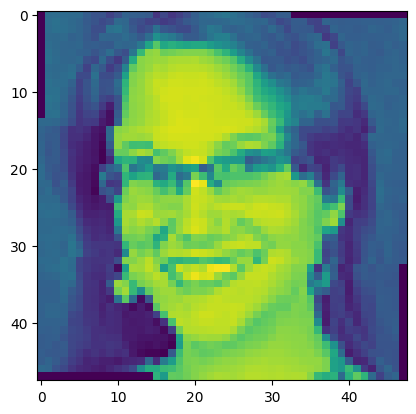

In [15]:
show_sample(*factory.training[7])

images.shape: torch.Size([128, 1, 48, 48])


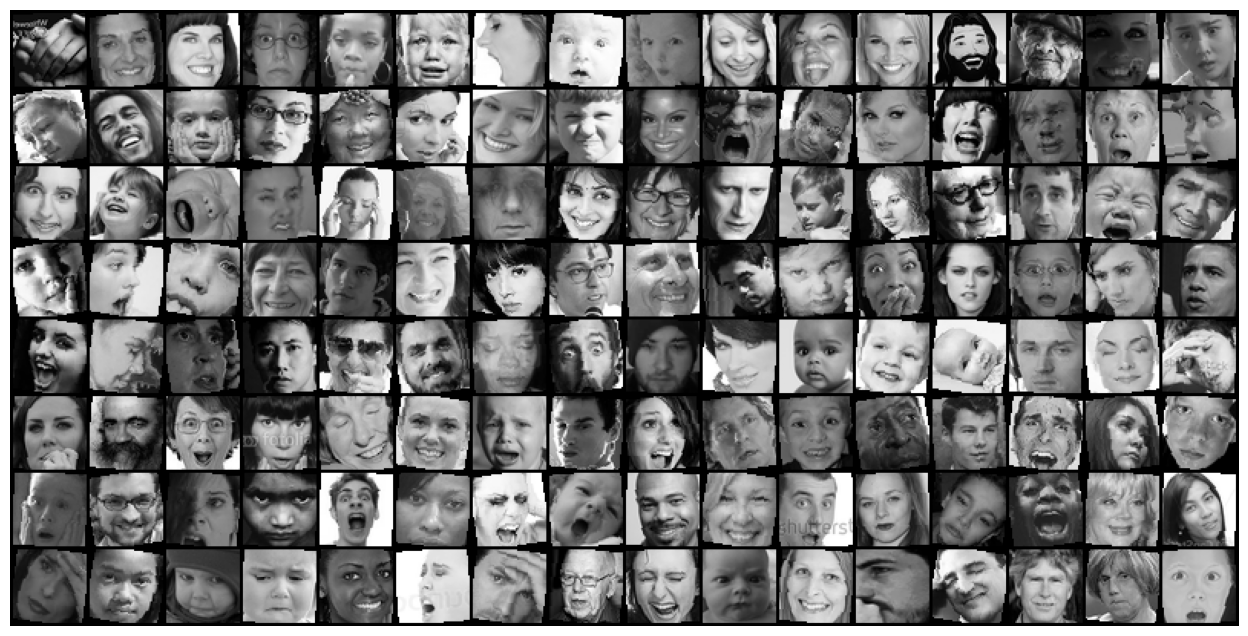

In [16]:
for images, _ in training_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [17]:
torch.cuda.is_available()

True

In [18]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [19]:
device = get_default_device()
device

device(type='cuda')

In [20]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [21]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [22]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [23]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [24]:
class Face(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}],last_lr: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch,result['lrs'][-1],result['val_loss'], result['val_acc']))

In [25]:
training_loader = DeviceDataLoader(training_loader, device)
validation_loader = DeviceDataLoader(validation_loader, device)
testing_loader = DeviceDataLoader(testing_loader, device)

In [26]:
class SeparableConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, dilation, groups=in_channels,
                                   bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, 1, 0, 1, 1, bias=bias)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x


class ResidualBlock(nn.Module):

    def __init__(self, in_channeld, out_channels):
        super(ResidualBlock, self).__init__()

        self.residual_conv = nn.Conv2d(in_channels=in_channeld, out_channels=out_channels, kernel_size=1, stride=2,
                                       bias=False)
        self.residual_bn = nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)

        self.sepConv1 = SeparableConv2d(in_channels=in_channeld, out_channels=out_channels, kernel_size=3, bias=False,
                                        padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)
        self.relu = nn.ReLU()

        self.sepConv2 = SeparableConv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, bias=False,
                                        padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)
        self.maxp = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        res = self.residual_conv(x)
        res = self.residual_bn(res)
        x = self.sepConv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.sepConv2(x)
        x = self.bn2(x)
        x = self.maxp(x)
        return res + x


class FaceCnnModel(Face):

    def __init__(self):
        super(FaceCnnModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(8, affine=True, momentum=0.99, eps=1e-3)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, bias=False)
        self.bn2 = nn.BatchNorm2d(8, momentum=0.99, eps=1e-3)
        self.relu2 = nn.ReLU()

        self.module1 = ResidualBlock(in_channeld=8, out_channels=16)
        self.module2 = ResidualBlock(in_channeld=16, out_channels=32)
        self.module3 = ResidualBlock(in_channeld=32, out_channels=64)
        self.module4 = ResidualBlock(in_channeld=64, out_channels=128)

        self.last_conv = nn.Conv2d(in_channels=128, out_channels=7, kernel_size=3, padding=1)
        self.avgp = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, input):
        x = input
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.module1(x)
        x = self.module2(x)
        x = self.module3(x)
        x = self.module4(x)
        x = self.last_conv(x)
        x = self.avgp(x)
        x = x.view((x.shape[0], -1))
        return x

# **Training**

In [27]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [28]:
model = to_device(FaceCnnModel(), device)

In [29]:
history = [evaluate(model, validation_loader)]
history

[{'val_loss': 1.9462635517120361, 'val_acc': 0.11206896603107452}]

In [30]:
max_lr=0.01
grad_clip = 0.1
weight_decay = 1e-4
epochs=10
opt_func = torch.optim.Adam

In [31]:
history += fit_one_cycle(epochs, max_lr, model, training_loader, validation_loader, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [0],last_lr: 0.0028, val_loss: 1.5422, val_acc: 0.4097


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [1],last_lr: 0.0076, val_loss: 1.3424, val_acc: 0.4676


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [2],last_lr: 0.0100, val_loss: 1.2767, val_acc: 0.5120


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [3],last_lr: 0.0095, val_loss: 1.1720, val_acc: 0.5609


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [4],last_lr: 0.0081, val_loss: 1.1655, val_acc: 0.5693


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [5],last_lr: 0.0061, val_loss: 1.1518, val_acc: 0.5605


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [6],last_lr: 0.0039, val_loss: 1.0991, val_acc: 0.5705


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [7],last_lr: 0.0019, val_loss: 1.0841, val_acc: 0.5995


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [8],last_lr: 0.0005, val_loss: 1.0677, val_acc: 0.5923


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [9],last_lr: 0.0000, val_loss: 1.0230, val_acc: 0.6169


In [32]:
torch.cuda.empty_cache()

In [33]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

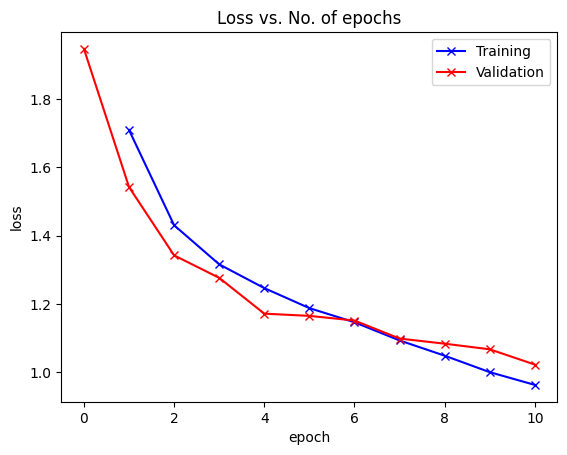

In [34]:
plot_losses(history)

In [35]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

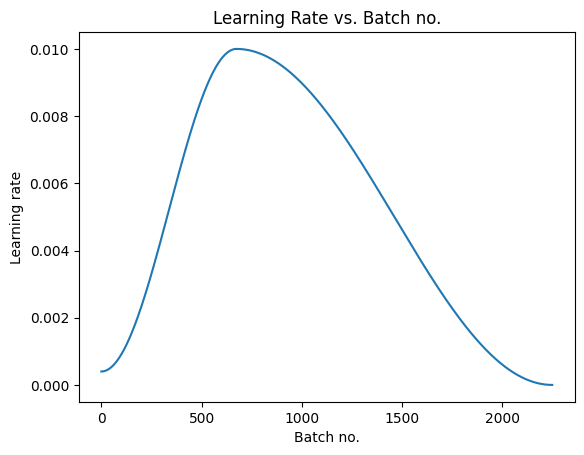

In [36]:
plot_lrs(history)

In [37]:
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    test=torch.max(prediction)
    print(test)
    index = prediction.cpu().data.numpy().argmax()
    print("Prediction: ", prediction)
    show_predicted(image, prediction)

tensor(4.9053, device='cuda:0', grad_fn=<MaxBackward1>)
Prediction:  tensor([ 4.9053,  2.6231,  1.8778, -3.7205,  0.1818, -3.7357, -0.8065],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor([[[0.1686, 0.1647, 0.1216,  ..., 0.2941, 0.4392, 0.5882],
         [0.2157, 0.1882, 0.1686,  ..., 0.2667, 0.4392, 0.5647],
         [0.1882, 0.2588, 0.2118,  ..., 0.2588, 0.4667, 0.5176],
         ...,
         [0.5882, 0.8196, 0.5765,  ..., 0.5686, 0.6275, 0.3765],
         [0.7647, 0.5686, 0.3922,  ..., 0.5176, 0.5451, 0.4157],
         [0.4980, 0.3294, 0.2745,  ..., 0.4510, 0.4157, 0.4078]]])
torch.Size([48, 48])
Labels: Angry(0)


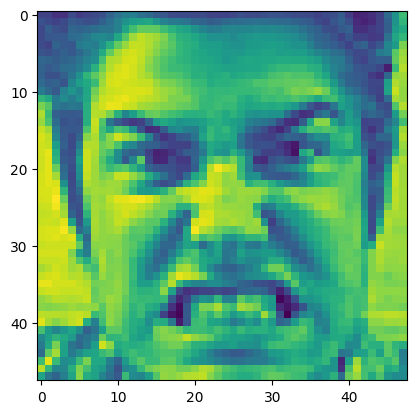

In [38]:
predict_single(factory.testing[40][0])

In [39]:
torch.save(model,'cnn.pt')

In [92]:
!pip install jovian --upgrade --quiet

In [93]:
import jovian

<IPython.core.display.Javascript object>

In [94]:
jovian.reset()
jovian.log_hyperparams(arch='CNN_facial_expression', 
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Hyperparams logged.


In [95]:
jovian.commit(project="Facial_expression_analysis", environment=None, outputs=['cifar10-resnet9.pth'])

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/aayush421999/Facial_expression_analysis


<IPython.core.display.Javascript object>

In [40]:
import numpy as np
mylist=[1.34,-2,30,14,5.555]
ind = np.argmax(mylist)
print(ind)

2
